# Bayesian Optimization with XGBoost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import google.colab

!wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/master/bayesian_optimization_util.py

!pip install scikit-optimize
!pip install xgboost
!pip install bayesian-optimization==0.6.0

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

--2020-07-07 01:38:11--  https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/master/bayesian_optimization_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1536 (1.5K) [text/plain]
Saving to: ‘bayesian_optimization_util.py’

bayesian_optimizati 100%[===================>]   1.50K  --.-KB/s    in 0s      

2020-07-07 01:38:12 (22.3 MB/s) - ‘bayesian_optimization_util.py’ saved [1536/1536]

     |████████████████████████████████| 81kB 2.1MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-0.6.0-cp36-none-any.whl size=10828 sha256=7ced967e4ce4cb8bcd451b195b10bdc75eff8d43d63eb70406699d622046d038
  Stored in directory: /root/.cache/pip/wheels/f5/ef/5c/9ff1d2d86ad1117bf4cd3f989356ae46fa907014ece63b09dd
Successfully buil

In [ ]:
pip list

## Read Data


In [ ]:
df = pd.read_csv('/content/drive/My Drive/NJIT Classes/Graduate/U20/CS634/Project 2/train.csv',nrows=1_000_000, usecols=[1,2,3,4,5,6,7])

#df = pd.read_csv('/content/drive/My Drive/NJIT/CS634/Project 2/train.csv', usecols=[1,2,3,4,5,6,7])

In [ ]:
df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
df['pickup_datetime']

0        2009-06-15 17:26:00+00:00
1        2010-01-05 16:52:00+00:00
2        2011-08-18 00:35:00+00:00
3        2012-04-21 04:30:00+00:00
4        2010-03-09 07:51:00+00:00
                    ...           
999995   2014-09-13 21:44:00+00:00
999996   2010-09-20 14:50:00+00:00
999997   2013-04-26 14:03:00+00:00
999998   2011-07-08 00:29:00+00:00
999999   2009-12-31 14:30:00+00:00
Name: pickup_datetime, Length: 1000000, dtype: datetime64[ns, UTC]

In [ ]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:00+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:00+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
999995,7.0,2014-09-13 21:44:00+00:00,-73.976676,40.785630,-73.959196,40.775114,1
999996,7.3,2010-09-20 14:50:00+00:00,-73.992103,40.671385,-73.992103,40.671385,2
999997,10.5,2013-04-26 14:03:00+00:00,-73.978423,40.751135,-73.993397,40.762197,5
999998,6.9,2011-07-08 00:29:00+00:00,-73.980317,40.759482,-73.976832,40.743122,1


## Clean

In [ ]:
# Remove observations with missing values
df.dropna(how='any', axis='rows', inplace=True)

# Removing observations with erroneous values
mask = df['pickup_longitude'].between(-75, -73)
mask &= df['dropoff_longitude'].between(-75, -73)
mask &= df['pickup_latitude'].between(40, 42)
mask &= df['dropoff_latitude'].between(40, 42)
mask &= df['passenger_count'].between(0, 8)
mask &= df['fare_amount'].between(0, 250)

df = df[mask]

## Feature Engineering
Manhattan distance provides a better approximation of actual travelled distance than haversine for most trips.

In [ ]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    
    return distance

In [ ]:
def transform(data):
    # Extract date attributes and then drop the pickup_datetime column
    data['hour'] = data['pickup_datetime'].dt.hour
    data['day'] = data['pickup_datetime'].dt.day
    data['month'] = data['pickup_datetime'].dt.month
    data['year'] = data['pickup_datetime'].dt.year
    data = data.drop('pickup_datetime', axis=1)

    # Distances to nearby airports, and city center
    # By reporting distances to these points, the model can somewhat triangulate other locations of interest
    nyc = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    data['distance_to_center'] = dist(nyc[1], nyc[0],
                                      data['pickup_latitude'], data['pickup_longitude'])
    data['pickup_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                         data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = dist(ewr[1], ewr[0], 
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = dist(ewr[1], ewr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    
    data['long_dist'] = data['pickup_longitude'] - data['dropoff_longitude']
    data['lat_dist'] = data['pickup_latitude'] - data['dropoff_latitude']
    
    data['dist'] = dist(data['pickup_latitude'], data['pickup_longitude'],
                        data['dropoff_latitude'], data['dropoff_longitude'])
    
    return data


df = transform(df)

## Train/Test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('fare_amount', axis=1),
                                                    df['fare_amount'], test_size=0.25)
del(df)
dtrain = xgb.DMatrix(X_train, label=y_train)
del(X_train)
dtest = xgb.DMatrix(X_test)
del(X_test)

## Training
Optimizing hyperparameters with bayesian optimization. 

In [ ]:
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=1000, nfold=10)    
    
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [ ]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
# Use the expected improvement acquisition function to handle negative numbers
xgb_bo.maximize(init_points=5, n_iter=10, acq='ei')

Initialization
----------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth | 
    1 | 15m49s |   -3.87127 |             0.8472 |    0.6559 |      4.1107 | 
    2 | 16m45s |   -3.75968 |             0.4234 |    0.4733 |      6.0638 | 
    3 | 08m30s |   -4.05186 |             0.3908 |    0.8311 |      3.1184 | 
    4 | 21m26s |   -3.80361 |             0.8262 |    0.0541 |      5.4394 | 
    5 | 11m48s |   -4.00454 |             0.7595 |    0.4346 |      3.0247 | 
Bayesian Optimization
----------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth | 
    6 | 34m12s |   -3.69691 |             0.9000 |    1.0000 |      7.0000 | 
    7 | 15m29s |   -3.75308 |             0.3000 |    1.0000 |      7.0000 | 
    8 | 27m20s |   -3.75137 |             0.9000 |    1.0000 |      6.0565 | 
    9 | 34m01s |   -3.69733 |

Extract the parameters of the best model.

In [ ]:
params = xgb_bo.res['max']['max_params']
params['max_depth'] = int(params['max_depth'])

## Testing

In [ ]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, dtrain, num_boost_round=1000)

# Predict on testing and training set
y_pred = model2.predict(dtest)
y_train_pred = model2.predict(dtrain)

# Report testing and training RMSE
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

## Feature Importance

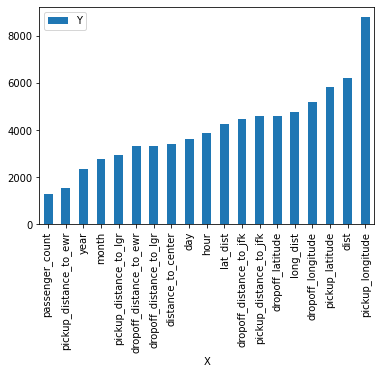

In [ ]:
import matplotlib.pyplot as plt
fscores = pd.DataFrame({'X': list(model2.get_fscore().keys()), 'Y': list(model2.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

## Predict on Holdout Set

In [ ]:
test = pd.read_csv('/content/drive/My Drive/NJIT/CS634/Project 2/test.csv').set_index('key')
test['pickup_datetime'] = test['pickup_datetime'].str.slice(0, 16)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

# Predict on holdout set
test = transform(test)
dtest = xgb.DMatrix(test)
y_pred_test = model2.predict(dtest)

## Submit predictions

In [ ]:
holdout = pd.DataFrame({'key': test.index, 'fare_amount': y_pred_test})
holdout.to_csv('/content/drive/My Drive/NJIT/CS634/Project 2/submission_Final.csv', index=False)

## Conclusion
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. Bayesian optimization is a sequential design strategy for global optimization of black-box functions that does not assume any functional forms.

Note that only 1 million of the 55 million rows were used for the prediction model due to Colab capacity. After applying Bayesian optimization to XGBoost, it gives a score of 3.20200 when submitting to Kaggle, ranked 442 among all 1484 submissions (top 30%). With less than 2% of the data used, it is still much better than linear models (scoring around 5). 

In fact, the score can be better if optimizing some hyperparameters (eg.increasing number of boosting rounds, number of folds, and number of iternations). However, it will be a very time-consuming process and probably out of Colab's capacity. 


